In [20]:
#Project Header and Imports
"""
DenseNet-121 Baseline Model for NIH Chest X-ray Classification
COSC 4368 Final Project - Group 13
Yla Herrera, Nicolas Mangilit, Kiriti Padavala, and Matt Tindall
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm

print("All libraries imported successfully!")

All libraries imported successfully!


In [21]:
# Set Random Seeds and Check Device
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# heck for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cpu


In [22]:
# Cell 3: Define Paths and Load Metadata
DATA_DIR = "data" 

# The dataset has images split across multiple folders: images_001 to images_012

#Load metadata
print("Loading metadata CSV...")
csv_path = os.path.join(DATA_DIR, "Data_Entry_2017.csv")
df = pd.read_csv(csv_path)

print(f"✓ Total number of images: {len(df)}")
print(f"\nDataset columns:")
print(df.columns.tolist())
print(f"\nFirst few rows:")
print(df.head())

#Look at image folders
print(f"\nChecking for image folders...")
image_folders = []
for i in range(1, 13):  #all folders
    folder_name = f"images_{i:03d}"
    folder_path = os.path.join(DATA_DIR, folder_name)
    if os.path.exists(folder_path):
        num_images = len([f for f in os.listdir(folder_path) if f.endswith('.png')])
        image_folders.append(folder_name)
        print(f"Found {folder_name} with {num_images} images")

print(f"\nTotal image folders found: {len(image_folders)}")


Loading metadata CSV...
✓ Total number of images: 112120

Dataset columns:
['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11']

First few rows:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA  

In [23]:
#Define Disease Categories
# The 14 disease categories in NIH Chest X-ray dataset
DISEASE_CATEGORIES = [
    'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
    'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
    'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
    'Pleural_Thickening', 'Hernia'
]

print(f"Number of disease categories: {len(DISEASE_CATEGORIES)}")
print(f"Disease categories: {DISEASE_CATEGORIES}")

Number of disease categories: 14
Disease categories: ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']



Disease distribution:
Infiltration          19894
Effusion              13317
Atelectasis           11559
Nodule                 6331
Mass                   5782
Pneumothorax           5302
Consolidation          4667
Pleural_Thickening     3385
Cardiomegaly           2776
Emphysema              2516
Edema                  2303
Fibrosis               1686
Pneumonia              1431
Hernia                  227
dtype: int64


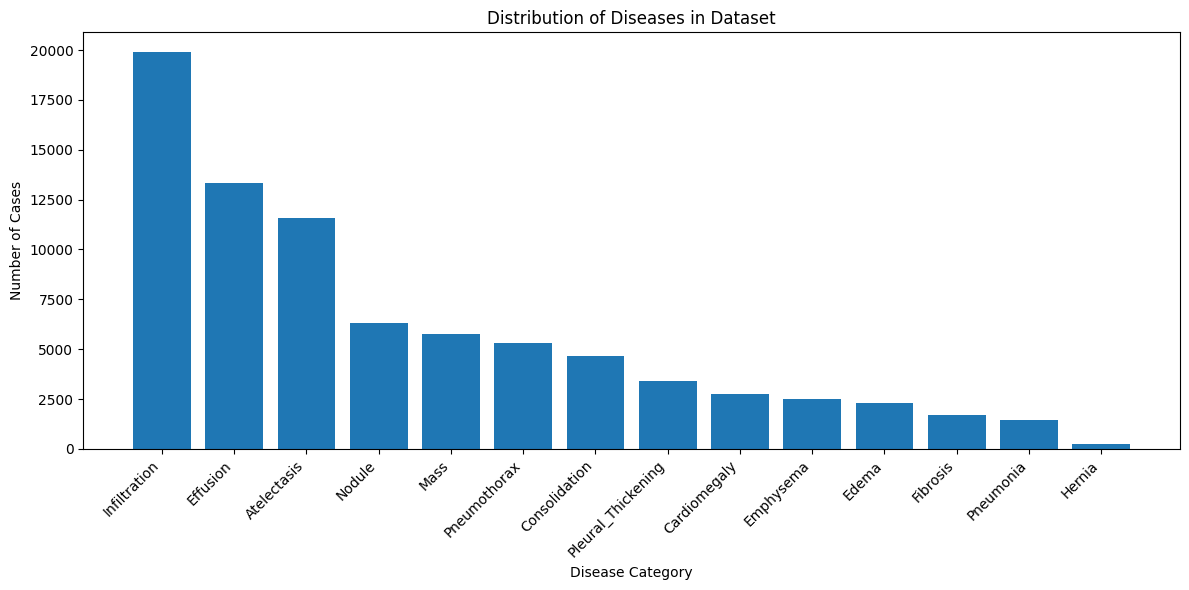

In [24]:
# Parse Labels and Create Binary Columns
# Parse labels (Finding Labels column contains multiple labels separated by |)
def parse_labels(label_string, disease_categories):
    """Convert label string to multi-hot encoded vector"""
    labels = np.zeros(len(disease_categories))
    if label_string != "No Finding":
        diseases = label_string.split('|')
        for disease in diseases:
            if disease in disease_categories:
                idx = disease_categories.index(disease)
                labels[idx] = 1
    return labels

# Add binary labels for each disease
for disease in DISEASE_CATEGORIES:
    df[disease] = df['Finding Labels'].apply(
        lambda x: 1 if disease in x else 0
    )

print(f"\nDisease distribution:")
print(df[DISEASE_CATEGORIES].sum().sort_values(ascending=False))

# Visualize disease distribution
plt.figure(figsize=(12, 6))
disease_counts = df[DISEASE_CATEGORIES].sum().sort_values(ascending=False)
plt.bar(range(len(disease_counts)), disease_counts.values)
plt.xticks(range(len(disease_counts)), disease_counts.index, rotation=45, ha='right')
plt.xlabel('Disease Category')
plt.ylabel('Number of Cases')
plt.title('Distribution of Diseases in Dataset')
plt.tight_layout()
plt.show()

In [25]:
class ChestXrayDataset(Dataset):
    """Custom Dataset for NIH Chest X-rays

    image_dir may be a single path (string) or a list/tuple of directories.
    If multiple directories are provided, __getitem__ will search them in order
    for the requested image filename.
    """

    def __init__(self, dataframe, image_dir, disease_categories, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        # allow a single path or multiple roots
        if isinstance(image_dir, (list, tuple)):
            self.image_dirs = list(image_dir)
        else:
            self.image_dirs = [image_dir]

        # keep original for compatibility
        self.image_dir = image_dir
        self.disease_categories = disease_categories
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image filename
        img_name = self.dataframe.loc[idx, 'Image Index']

        # Try each candidate root until file is found
        img_path = None
        for root in self.image_dirs:
            candidate = os.path.join(root, img_name)
            if os.path.exists(candidate):
                img_path = candidate
                break

        if img_path is None:
            # helpful message showing where we looked
            raise FileNotFoundError(f"Image '{img_name}' not found in any of: {self.image_dirs}")

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Get labels (multi-hot encoded)
        labels = self.dataframe.loc[idx, self.disease_categories].values.astype(np.float32)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(labels)

In [26]:
# Define transforms for training and validation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

print("Data transforms defined:")
print(f"  - Train: Resize(224x224), RandomHorizontalFlip, ToTensor, Normalize")
print(f"  - Val: Resize(224x224), ToTensor, Normalize")

Data transforms defined:
  - Train: Resize(224x224), RandomHorizontalFlip, ToTensor, Normalize
  - Val: Resize(224x224), ToTensor, Normalize


In [27]:
# Train/Validation Split
# Simple train/validation split (80/20)
# For your project, you may want to use the official NIH train/val/test split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
train_df = train_df.sample(n=8000, random_state=42)
val_df = val_df.sample(n=2000, random_state=42)
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"\nTrain/Val split ratio: {len(train_df)/len(df):.2%} / {len(val_df)/len(df):.2%}")

Train set size: 8000
Validation set size: 2000

Train/Val split ratio: 7.14% / 1.78%


In [28]:
# Create datasets
DATA_DIR = "data"

# The images are split across multiple folders images_001..images_012 (each contains an inner 'images' folder).
# Build a list of directories to search for files and pass that to the dataset so it can locate each image.
IMAGE_DIRS = [os.path.join(DATA_DIR, f"images_{i:03d}", "images") for i in range(1, 13)]
# keep only existing directories (helps if some folders are missing locally)
IMAGE_DIRS = [p for p in IMAGE_DIRS if os.path.exists(p)]
print(f"Found {len(IMAGE_DIRS)} image directories; using:\n  - " + "\n  - ".join(IMAGE_DIRS))

train_dataset = ChestXrayDataset(
    train_df, 
    IMAGE_DIRS, 
    DISEASE_CATEGORIES, 
    transform=train_transform
)

val_dataset = ChestXrayDataset(
    val_df, 
    IMAGE_DIRS, 
    DISEASE_CATEGORIES, 
    transform=val_transform,
)

# Create dataloaders
# Use a smaller batch size on CPU and avoid worker processes on Windows (spawn overhead can be very slow)
BATCH_SIZE = 8  # Reduce for CPU (increase if you have more RAM/CPU)
if os.name == 'nt':
    NUM_WORKERS = 0
else:
    NUM_WORKERS = 4

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
)

print(f"DataLoaders created:")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Val batches: {len(val_loader)}")
print(f"  - Num workers: {NUM_WORKERS}")

Found 12 image directories; using:
  - data\images_001\images
  - data\images_002\images
  - data\images_003\images
  - data\images_004\images
  - data\images_005\images
  - data\images_006\images
  - data\images_007\images
  - data\images_008\images
  - data\images_009\images
  - data\images_010\images
  - data\images_011\images
  - data\images_012\images
DataLoaders created:
  - Batch size: 8
  - Train batches: 1000
  - Val batches: 250
  - Num workers: 0


In [29]:
# Diagnostic & Quick Debug Training (CPU-friendly)
# Measures DataLoader load/transfer times and runs a short 1-epoch training on a small subset
import time
from torch.utils.data import Subset

print('Device:', device)
print('Train dataset length:', len(train_dataset))
print('Train loader batches:', len(train_loader))
print('Batch size:', BATCH_SIZE, 'Num workers:', NUM_WORKERS)

# Ensure a model is available on CPU for the debug run
if 'model' not in globals():
    print("`model` not found — initializing DenseNet121 (pretrained=False) for debug.")
    try:
        model = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=False)
    except NameError:
        print("`DenseNet121` class not found — building model directly from torchvision.models")
        base = models.densenet121(pretrained=False)
        num_features = base.classifier.in_features
        base.classifier = nn.Linear(num_features, len(DISEASE_CATEGORIES))
        model = base

# Move model to CPU for this debug run
model = model.to('cpu')

# Ensure a loss function exists
if 'criterion' not in globals():
    criterion = nn.BCEWithLogitsLoss()

# Use a small subset for a quick smoke test
DEBUG_SAMPLES = min(200, len(train_dataset))
subset_idx = list(range(DEBUG_SAMPLES))
debug_loader = DataLoader(Subset(train_dataset, subset_idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Measure first few batches (load + forward+loss computation)
load_times = []
step_times = []

it = iter(debug_loader)
for i in range(min(5, len(debug_loader))):
    t0 = time.time()
    imgs, lbls = next(it)
    t1 = time.time()
    load_times.append(t1 - t0)

    t2 = time.time()
    # ensure tensors on CPU (this notebook runs on CPU)
    outputs = model(imgs)
    loss = criterion(outputs, lbls)
    t3 = time.time()
    step_times.append(t3 - t2)
    print(f"Batch {i+1}: load={load_times[-1]:.3f}s, forward+loss={step_times[-1]:.3f}s")

if load_times:
    print(f"Avg load time: {sum(load_times)/len(load_times):.3f}s, avg forward+loss: {sum(step_times)/len(step_times):.3f}s")

# Quick 1-epoch training on the small subset (use CPU)
print('\nStarting short debug training (1 epoch over {} samples)'.format(DEBUG_SAMPLES))
optimizer_debug = optim.Adam(model.parameters(), lr=1e-4)

model.train()
start = time.time()
for i, (imgs, lbls) in enumerate(debug_loader, 1):
    t0 = time.time()
    optimizer_debug.zero_grad()
    outputs = model(imgs)
    loss = criterion(outputs, lbls)
    loss.backward()
    optimizer_debug.step()
    t1 = time.time()
    if i % 10 == 0 or i == len(debug_loader):
        print(f"Step {i}/{len(debug_loader)} - loss={loss.item():.4f} step_time={t1-t0:.3f}s")
end = time.time()
print(f"Debug epoch complete in {end - start:.1f}s")


Device: cpu
Train dataset length: 8000
Train loader batches: 1000
Batch size: 8 Num workers: 0
Batch 1: load=0.313s, forward+loss=0.571s
Batch 1: load=0.313s, forward+loss=0.571s
Batch 2: load=0.202s, forward+loss=0.483s
Batch 2: load=0.202s, forward+loss=0.483s
Batch 3: load=0.250s, forward+loss=0.400s
Batch 3: load=0.250s, forward+loss=0.400s
Batch 4: load=0.217s, forward+loss=0.383s
Batch 4: load=0.217s, forward+loss=0.383s
Batch 5: load=0.226s, forward+loss=0.391s
Avg load time: 0.242s, avg forward+loss: 0.446s

Starting short debug training (1 epoch over 200 samples)
Batch 5: load=0.226s, forward+loss=0.391s
Avg load time: 0.242s, avg forward+loss: 0.446s

Starting short debug training (1 epoch over 200 samples)
Step 10/25 - loss=0.2738 step_time=1.234s
Step 10/25 - loss=0.2738 step_time=1.234s
Step 20/25 - loss=0.0426 step_time=1.157s
Step 20/25 - loss=0.0426 step_time=1.157s
Step 25/25 - loss=0.1968 step_time=1.033s
Debug epoch complete in 41.3s
Step 25/25 - loss=0.1968 step_tim

In [30]:
# Quick smoke-check: verify datasets & that an example image file exists
print('IMAGE_DIRS:', IMAGE_DIRS)
print('Train dataset length:', len(train_dataset))
print('Val dataset length:', len(val_dataset))

# Small helper to locate a filename inside the configured roots
from pathlib import Path

def find_image_path(image_name, search_dirs):
    for d in search_dirs:
        candidate = os.path.join(d, image_name)
        if os.path.exists(candidate):
            return candidate
    return None

sample_name = train_df.iloc[0]['Image Index']
print('Sample image name (from train_df):', sample_name)
found = find_image_path(sample_name, IMAGE_DIRS)
print('Found sample path:' , found)

IMAGE_DIRS: ['data\\images_001\\images', 'data\\images_002\\images', 'data\\images_003\\images', 'data\\images_004\\images', 'data\\images_005\\images', 'data\\images_006\\images', 'data\\images_007\\images', 'data\\images_008\\images', 'data\\images_009\\images', 'data\\images_010\\images', 'data\\images_011\\images', 'data\\images_012\\images']
Train dataset length: 8000
Val dataset length: 2000
Sample image name (from train_df): 00005750_025.png
Found sample path: data\images_003\images\00005750_025.png


In [31]:
# Define DenseNet-121 Model
class DenseNet121(nn.Module):
    """DenseNet-121 for multi-label chest X-ray classification"""
    
    def __init__(self, num_classes=14, pretrained=True):
        super(DenseNet121, self).__init__()
        
        # Load pre-trained DenseNet-121
        self.densenet = models.densenet121(pretrained=pretrained)
        
        # Get number of input features for the classifier
        num_features = self.densenet.classifier.in_features
        
        # Replace the classifier for multi-label classification
        self.densenet.classifier = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.densenet(x)

print("DenseNet121 model class defined!")

DenseNet121 model class defined!


In [32]:

# Initialize model
model = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=True)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model initialized and moved to {device}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model initialized and moved to cpu
Total parameters: 6,968,206
Trainable parameters: 6,968,206


In [33]:
# Define Loss Function and Optimizer
# Binary Cross Entropy with Logits Loss (suitable for multi-label classification)
criterion = nn.BCEWithLogitsLoss()

# Adam optimizer
LEARNING_RATE = 1e-4
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

print(f"Loss function: BCEWithLogitsLoss")
print(f"Optimizer: Adam (lr={LEARNING_RATE})")
print(f"Scheduler: ReduceLROnPlateau")

Loss function: BCEWithLogitsLoss
Optimizer: Adam (lr=0.0001)
Scheduler: ReduceLROnPlateau


In [34]:
# Training Function
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    
    for images, labels in tqdm(dataloader, desc="Training"):
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

print("Training function defined!")

Training function defined!


In [35]:
# Validation Function
def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            # Store predictions and labels for metrics
            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader.dataset)
    
    # Concatenate all batches
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    
    # Calculate AUC for each disease
    auc_scores = []
    for i in range(all_labels.shape[1]):
        if len(np.unique(all_labels[:, i])) > 1:  # Check if both classes present
            auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    
    mean_auc = np.nanmean(auc_scores)
    
    return epoch_loss, mean_auc, auc_scores

print("Validation function defined!")

Validation function defined!


In [36]:
#Training Loop
NUM_EPOCHS = 5  # Start with a few epochs to test

print(f"Starting Training - {NUM_EPOCHS} epochs")

train_losses = []
val_losses = []
val_aucs = []

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Validate
    val_loss, mean_auc, auc_scores = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_aucs.append(mean_auc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    # Print metrics
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Mean AUC: {mean_auc:.4f}")
    
    print("\nPer-disease AUC scores:")
    for disease, auc in zip(DISEASE_CATEGORIES, auc_scores):
        if not np.isnan(auc):
            print(f"  {disease:25s}: {auc:.4f}")


Starting Training - 5 epochs

Epoch 1/5


Validation: 100%|██████████| 250/250 [02:48<00:00,  1.48it/s]



Train Loss: 0.1849
Val Loss: 0.1627
Mean AUC: 0.7477

Per-disease AUC scores:
  Atelectasis              : 0.7678
  Cardiomegaly             : 0.7696
  Effusion                 : 0.8326
  Infiltration             : 0.6845
  Mass                     : 0.7395
  Nodule                   : 0.6383
  Pneumonia                : 0.7335
  Pneumothorax             : 0.8026
  Consolidation            : 0.7590
  Edema                    : 0.8473
  Emphysema                : 0.7583
  Fibrosis                 : 0.7285
  Pleural_Thickening       : 0.7025
  Hernia                   : 0.7043

Epoch 2/5


Validation: 100%|██████████| 250/250 [02:26<00:00,  1.71it/s]



Train Loss: 0.1598
Val Loss: 0.1587
Mean AUC: 0.7582

Per-disease AUC scores:
  Atelectasis              : 0.7734
  Cardiomegaly             : 0.8531
  Effusion                 : 0.8450
  Infiltration             : 0.6871
  Mass                     : 0.7686
  Nodule                   : 0.6452
  Pneumonia                : 0.7215
  Pneumothorax             : 0.8153
  Consolidation            : 0.7722
  Edema                    : 0.8484
  Emphysema                : 0.7744
  Fibrosis                 : 0.7015
  Pleural_Thickening       : 0.7268
  Hernia                   : 0.6826

Epoch 3/5


Validation: 100%|██████████| 250/250 [02:26<00:00,  1.71it/s]



Train Loss: 0.1534
Val Loss: 0.1584
Mean AUC: 0.7608

Per-disease AUC scores:
  Atelectasis              : 0.7739
  Cardiomegaly             : 0.8548
  Effusion                 : 0.8470
  Infiltration             : 0.6921
  Mass                     : 0.7821
  Nodule                   : 0.6393
  Pneumonia                : 0.7573
  Pneumothorax             : 0.8234
  Consolidation            : 0.7628
  Edema                    : 0.8456
  Emphysema                : 0.8090
  Fibrosis                 : 0.6796
  Pleural_Thickening       : 0.7349
  Hernia                   : 0.6486

Epoch 4/5


Validation: 100%|██████████| 250/250 [02:24<00:00,  1.73it/s]



Train Loss: 0.1471
Val Loss: 0.1555
Mean AUC: 0.7783

Per-disease AUC scores:
  Atelectasis              : 0.7814
  Cardiomegaly             : 0.8706
  Effusion                 : 0.8536
  Infiltration             : 0.6767
  Mass                     : 0.8019
  Nodule                   : 0.6517
  Pneumonia                : 0.7346
  Pneumothorax             : 0.8380
  Consolidation            : 0.7658
  Edema                    : 0.8591
  Emphysema                : 0.8321
  Fibrosis                 : 0.7325
  Pleural_Thickening       : 0.7512
  Hernia                   : 0.7470

Epoch 5/5


Validation: 100%|██████████| 250/250 [02:40<00:00,  1.55it/s]


Train Loss: 0.1399
Val Loss: 0.1573
Mean AUC: 0.7816

Per-disease AUC scores:
  Atelectasis              : 0.7751
  Cardiomegaly             : 0.8583
  Effusion                 : 0.8563
  Infiltration             : 0.6915
  Mass                     : 0.8276
  Nodule                   : 0.6683
  Pneumonia                : 0.7946
  Pneumothorax             : 0.8010
  Consolidation            : 0.7779
  Edema                    : 0.8529
  Emphysema                : 0.8017
  Fibrosis                 : 0.7653
  Pleural_Thickening       : 0.7768
  Hernia                   : 0.6943


Model saved to densenet121_baseline.pth


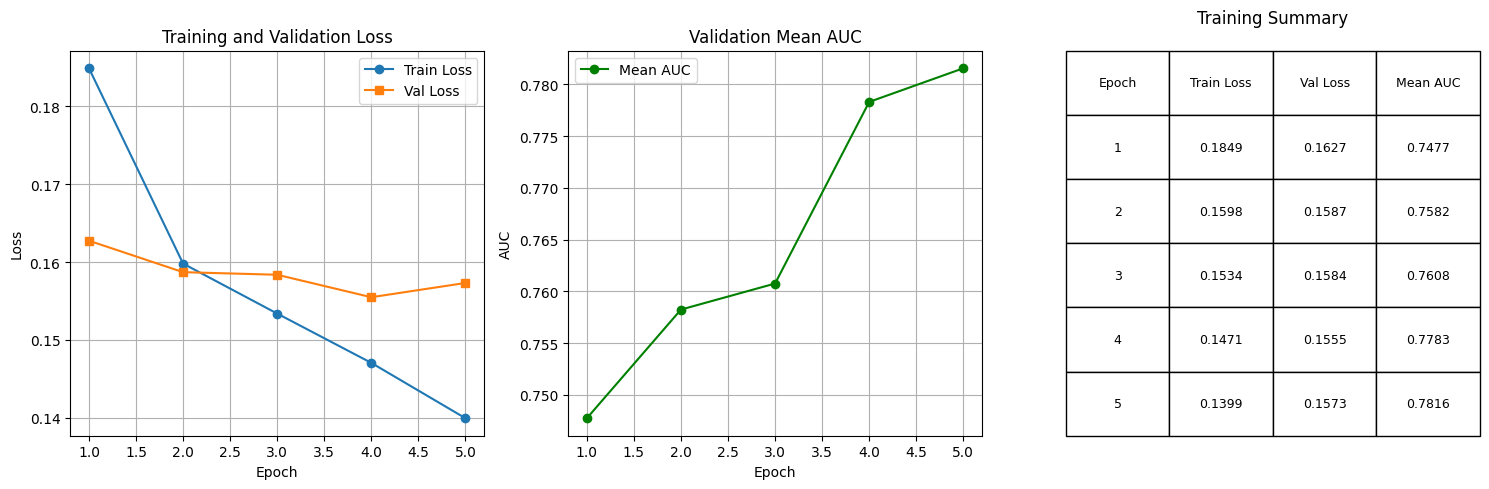

Training curves saved to 'training_curves.png'

FINAL RESULTS SUMMARY

Best Validation AUC: 0.7816 (Epoch 5)
Final Validation AUC: 0.7816
Final Train Loss: 0.1399
Final Val Loss: 0.1573

Baseline model training complete!
Next steps: Implement bias mitigation techniques


In [37]:
# Save Model
# Save the trained model
MODEL_SAVE_PATH = "densenet121_baseline.pth"
torch.save({
    'epoch': NUM_EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'val_aucs': val_aucs,
}, MODEL_SAVE_PATH)

print(f"Model saved to {MODEL_SAVE_PATH}")

# Plot Training Curves
plt.figure(figsize=(15, 5))

# Loss curves
plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, marker='s', label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# AUC curve
plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS+1), val_aucs, marker='o', color='green', label='Mean AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Validation Mean AUC')
plt.legend()
plt.grid(True)

# Summary table
plt.subplot(1, 3, 3)
plt.axis('off')
summary_data = []
for i in range(NUM_EPOCHS):
    summary_data.append([i+1, f"{train_losses[i]:.4f}", f"{val_losses[i]:.4f}", f"{val_aucs[i]:.4f}"])

table = plt.table(cellText=summary_data,
                  colLabels=['Epoch', 'Train Loss', 'Val Loss', 'Mean AUC'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
plt.title('Training Summary', pad=20)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training curves saved to 'training_curves.png'")

# Final Results Summary
print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(f"\nBest Validation AUC: {max(val_aucs):.4f} (Epoch {val_aucs.index(max(val_aucs))+1})")
print(f"Final Validation AUC: {val_aucs[-1]:.4f}")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

print("\n" + "="*60)
print("Baseline model training complete!")
print("Next steps: Implement bias mitigation techniques")
print("="*60)

MODEL 2: BASELINE + OVERSAMPLING

Verifying required variables...
✓ All required variables found
✓ DenseNet121 class already exists
✓ Training functions already exist

ANALYZING CLASS IMBALANCE

Original Training Set Disease Distribution:
Infiltration          1369
Effusion               919
Atelectasis            834
Nodule                 436
Mass                   401
Pneumothorax           382
Consolidation          334
Pleural_Thickening     244
Emphysema              190
Cardiomegaly           188
Edema                  160
Pneumonia              104
Fibrosis               100
Hernia                  18
dtype: int64

Most common disease: Infiltration (1369 cases)
Least common disease: Hernia (18 cases)
Imbalance ratio: 76.06:1


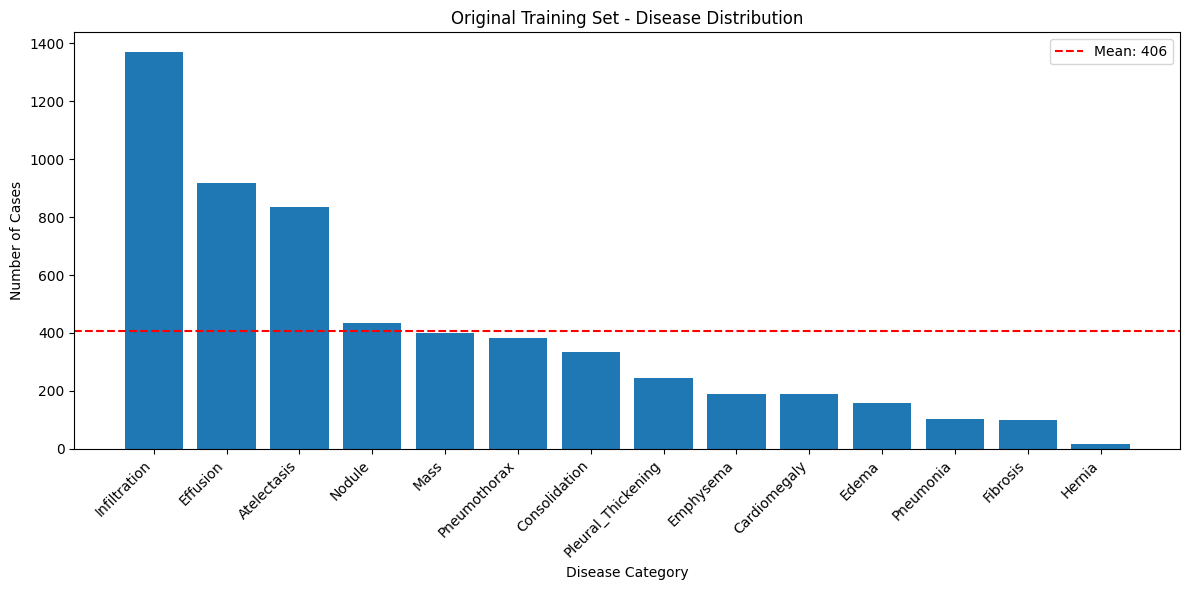


APPLYING OVERSAMPLING

Validating images in original dataset...
This may take a moment...
✓ All 8000 samples have valid images

Target count per disease: 684
(50% of most common disease: 1369)
  Cardiomegaly             :   188 ->   684 (+  496)
  Mass                     :   401 ->   684 (+  283)
  Nodule                   :   436 ->   684 (+  248)
  Pneumonia                :   104 ->   684 (+  580)
  Pneumothorax             :   382 ->   684 (+  302)
  Consolidation            :   334 ->   684 (+  350)
  Edema                    :   160 ->   684 (+  524)
  Emphysema                :   190 ->   684 (+  494)
  Fibrosis                 :   100 ->   684 (+  584)
  Pleural_Thickening       :   244 ->   684 (+  440)
  Hernia                   :    18 ->   684 (+  666)

Original training set size: 8000
Oversampled training set size: 12967
Increase: +4967 samples (62.1%)

VALIDATING VALIDATION DATASET

Checking validation images...
✓ All 2000 validation samples are valid

VISUALIZING NEW D

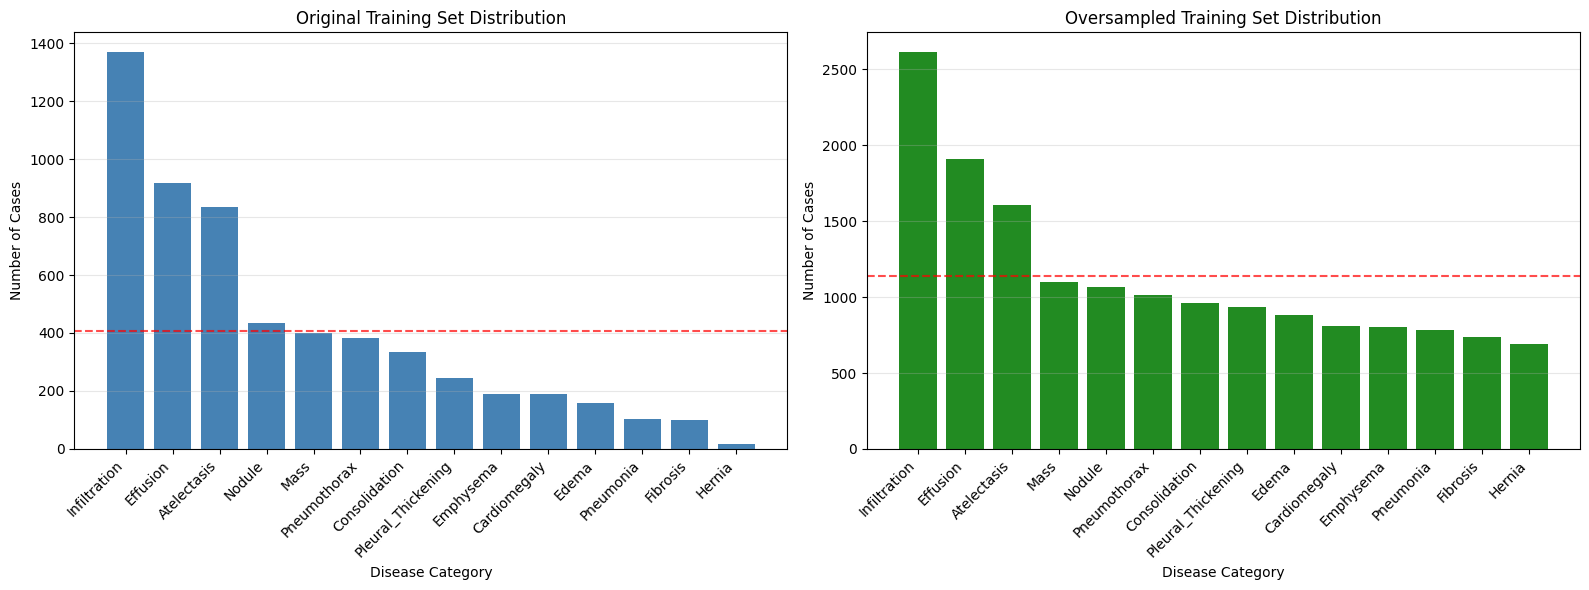

c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



New distribution statistics:
Mean cases per disease: 1136
Std dev: 545
New imbalance ratio: 3.79:1

CREATING OVERSAMPLED DATASETS
✓ Oversampled train dataset size: 12967
✓ Validation dataset size: 2000
✓ Train batches: 1621
✓ Val batches: 250
✓ Using num_workers=0 (single process - safer for Jupyter)

INITIALIZING MODEL 2
⚠️  Note: Using pretrained=False to avoid SSL certificate issues
   Model will train from scratch instead of using ImageNet weights
✓ Model initialized: DenseNet-121
✓ Loss: BCEWithLogitsLoss
✓ Optimizer: Adam (lr=0.0001)
✓ Scheduler: ReduceLROnPlateau

TRAINING MODEL 2 (WITH OVERSAMPLING)

Epoch 1/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:33<00:00,  1.63it/s]



Train Loss: 0.2780
Val Loss: 0.1963
Mean AUC: 0.6506

Per-disease AUC scores:
  Atelectasis              : 0.6837
  Cardiomegaly             : 0.6259
  Effusion                 : 0.7126
  Infiltration             : 0.6446
  Mass                     : 0.6483
  Nodule                   : 0.5721
  Pneumonia                : 0.6422
  Pneumothorax             : 0.6866
  Consolidation            : 0.6948
  Edema                    : 0.7897
  Emphysema                : 0.5779
  Fibrosis                 : 0.6590
  Pleural_Thickening       : 0.5877
  Hernia                   : 0.5833

Epoch 2/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:25<00:00,  1.72it/s]



Train Loss: 0.2542
Val Loss: 0.1931
Mean AUC: 0.6547

Per-disease AUC scores:
  Atelectasis              : 0.7134
  Cardiomegaly             : 0.6772
  Effusion                 : 0.7171
  Infiltration             : 0.6191
  Mass                     : 0.6570
  Nodule                   : 0.5949
  Pneumonia                : 0.6358
  Pneumothorax             : 0.7326
  Consolidation            : 0.6802
  Edema                    : 0.7686
  Emphysema                : 0.5899
  Fibrosis                 : 0.6275
  Pleural_Thickening       : 0.6052
  Hernia                   : 0.5472

Epoch 3/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:32<00:00,  1.63it/s]



Train Loss: 0.2375
Val Loss: 0.1856
Mean AUC: 0.6812

Per-disease AUC scores:
  Atelectasis              : 0.7275
  Cardiomegaly             : 0.7714
  Effusion                 : 0.7595
  Infiltration             : 0.6597
  Mass                     : 0.6833
  Nodule                   : 0.6240
  Pneumonia                : 0.6099
  Pneumothorax             : 0.7168
  Consolidation            : 0.7144
  Edema                    : 0.7716
  Emphysema                : 0.6610
  Fibrosis                 : 0.6055
  Pleural_Thickening       : 0.6110
  Hernia                   : 0.6218

Epoch 4/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:28<00:00,  1.68it/s]



Train Loss: 0.2187
Val Loss: 0.1888
Mean AUC: 0.6857

Per-disease AUC scores:
  Atelectasis              : 0.7324
  Cardiomegaly             : 0.7269
  Effusion                 : 0.7789
  Infiltration             : 0.6590
  Mass                     : 0.6859
  Nodule                   : 0.6084
  Pneumonia                : 0.6285
  Pneumothorax             : 0.7378
  Consolidation            : 0.7246
  Edema                    : 0.7781
  Emphysema                : 0.6330
  Fibrosis                 : 0.6168
  Pleural_Thickening       : 0.6782
  Hernia                   : 0.6116

Epoch 5/5
----------------------------------------


Validation: 100%|██████████| 250/250 [02:26<00:00,  1.71it/s]



Train Loss: 0.1972
Val Loss: 0.1849
Mean AUC: 0.6742

Per-disease AUC scores:
  Atelectasis              : 0.7227
  Cardiomegaly             : 0.7473
  Effusion                 : 0.7874
  Infiltration             : 0.6531
  Mass                     : 0.6819
  Nodule                   : 0.5813
  Pneumonia                : 0.6881
  Pneumothorax             : 0.7649
  Consolidation            : 0.7068
  Edema                    : 0.7874
  Emphysema                : 0.7013
  Fibrosis                 : 0.5458
  Pleural_Thickening       : 0.5752
  Hernia                   : 0.4950

MODEL 2 TRAINING COMPLETE!

✓ Model 2 saved to densenet121_oversampled.pth

VISUALIZING MODEL 2 RESULTS


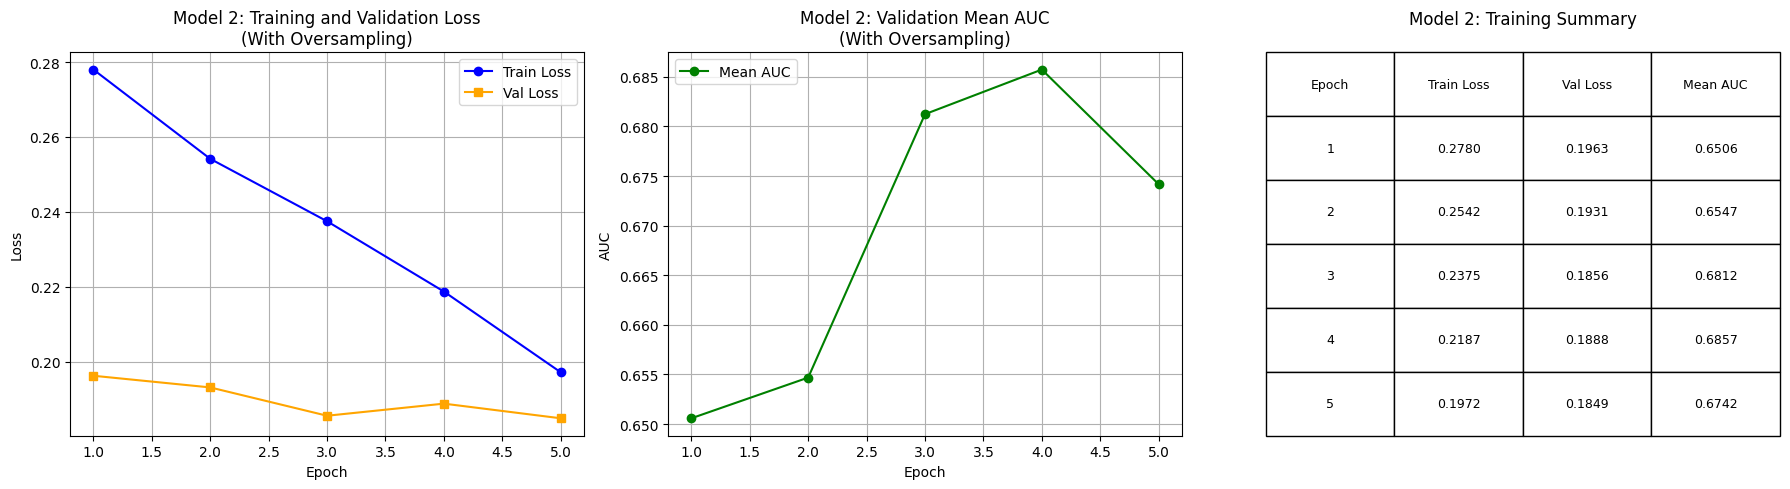

✓ Training curves saved to 'model2_training_curves.png'

MODEL 2: FINAL RESULTS SUMMARY

Best Validation AUC: 0.6857 (Epoch 4)
Final Validation AUC: 0.6742
Final Train Loss: 0.1972
Final Val Loss: 0.1849

Dataset Info:
  Original training samples: 8000
  Oversampled training samples: 12967
  Original validation samples: 2000
  Valid validation samples: 2000

Model 2 (Oversampling) Complete!


In [38]:
# Model 2: Baseline + Oversampling
print("="*60)
print("MODEL 2: BASELINE + OVERSAMPLING")
print("="*60)

# VERIFY AND DEFINE REQUIRED COMPONENTS
print("\nVerifying required variables...")

# Check required variables
required_vars = ['train_df', 'val_df', 'DISEASE_CATEGORIES', 'IMAGE_DIRS', 
                 'train_transform', 'val_transform', 'BATCH_SIZE', 'NUM_WORKERS', 
                 'device', 'LEARNING_RATE', 'ChestXrayDataset']

missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print(f"\n⚠️  WARNING: Missing variables: {missing_vars}")
    print("Please run all baseline model cells first!")
else:
    print("✓ All required variables found")

# Define or verify DenseNet121 class
if 'DenseNet121' not in globals():
    print("\nDefining DenseNet121 class...")
    
    class DenseNet121(nn.Module):
        """DenseNet-121 for multi-label chest X-ray classification"""
        
        def __init__(self, num_classes=14, pretrained=True):
            super(DenseNet121, self).__init__()
            
            # Load pre-trained DenseNet-121 with updated API
            if pretrained:
                try:
                    # Try new API first
                    from torchvision.models import DenseNet121_Weights
                    self.densenet = models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
                except:
                    # Fallback to old API
                    self.densenet = models.densenet121(pretrained=True)
            else:
                self.densenet = models.densenet121(weights=None)
            
            # Get number of input features for the classifier
            num_features = self.densenet.classifier.in_features
            
            # Replace the classifier for multi-label classification
            self.densenet.classifier = nn.Linear(num_features, num_classes)
        
        def forward(self, x):
            return self.densenet(x)
    
    print("✓ DenseNet121 class defined")
else:
    print("✓ DenseNet121 class already exists")

if 'train_epoch' not in globals():
    print("\nDefining training functions...")
    
    def train_epoch(model, dataloader, criterion, optimizer, device):
        """Train for one epoch"""
        model.train()
        running_loss = 0.0
        
        for images, labels in tqdm(dataloader, desc="Training"):
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        return epoch_loss

    def validate_epoch(model, dataloader, criterion, device):
        """Validate for one epoch"""
        model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in tqdm(dataloader, desc="Validation"):
                images = images.to(device)
                labels = labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * images.size(0)
                all_labels.append(labels.cpu().numpy())
                all_preds.append(torch.sigmoid(outputs).cpu().numpy())
        
        epoch_loss = running_loss / len(dataloader.dataset)
        all_labels = np.concatenate(all_labels, axis=0)
        all_preds = np.concatenate(all_preds, axis=0)
        
        # Calculate AUC for each disease
        auc_scores = []
        for i in range(all_labels.shape[1]):
            if len(np.unique(all_labels[:, i])) > 1:
                auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                auc_scores.append(auc)
            else:
                auc_scores.append(np.nan)
        
        mean_auc = np.nanmean(auc_scores)
        return epoch_loss, mean_auc, auc_scores
    
    print("✓ Training functions defined")
else:
    print("✓ Training functions already exist")

# STEP 1: Analyze Class Imbalance
print("\n" + "="*60)
print("ANALYZING CLASS IMBALANCE")
print("="*60)

disease_counts = train_df[DISEASE_CATEGORIES].sum().sort_values(ascending=False)
print("\nOriginal Training Set Disease Distribution:")
print(disease_counts)
print(f"\nMost common disease: {disease_counts.index[0]} ({disease_counts.values[0]} cases)")
print(f"Least common disease: {disease_counts.index[-1]} ({disease_counts.values[-1]} cases)")
print(f"Imbalance ratio: {disease_counts.values[0] / disease_counts.values[-1]:.2f}:1")

# Visualize original distribution
plt.figure(figsize=(12, 6))
plt.bar(range(len(disease_counts)), disease_counts.values)
plt.xticks(range(len(disease_counts)), disease_counts.index, rotation=45, ha='right')
plt.xlabel('Disease Category')
plt.ylabel('Number of Cases')
plt.title('Original Training Set - Disease Distribution')
plt.axhline(y=disease_counts.mean(), color='r', linestyle='--', label=f'Mean: {disease_counts.mean():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

#
# STEP 2: Apply Oversampling Strategy
print("\n" + "="*60)
print("APPLYING OVERSAMPLING")
print("="*60)

def check_image_exists(img_name, image_dirs):
    """Check if image file exists in any of the directories"""
    for root in image_dirs:
        candidate = os.path.join(root, img_name)
        if os.path.exists(candidate):
            return True
    return False

def check_image_valid(img_name, image_dirs):
    """Check if image file exists AND can be opened without errors"""
    for root in image_dirs:
        candidate = os.path.join(root, img_name)
        if os.path.exists(candidate):
            try:
                # Try to actually open and verify the image
                img = Image.open(candidate)
                img.verify()  # Verify it's a valid image
                return True
            except Exception:
                # Image is corrupted or can't be opened
                return False
    return False

def oversample_minority_classes(df, disease_categories, image_dirs, target_ratio=0.5):
    """
    Oversample underrepresented diseases in the dataset.
    Only includes samples where image files actually exist and are valid.
    
    Args:
        df: DataFrame with disease labels
        disease_categories: List of disease column names
        image_dirs: List of directories to search for images
        target_ratio: Target ratio relative to most common class (0.5 = 50% of max)
    
    Returns:
        Oversampled DataFrame
    """
    # Filter out any samples with missing or corrupted images
    print("\nValidating images in original dataset...")
    print("This may take a moment...")
    
    valid_mask = df['Image Index'].apply(lambda x: check_image_valid(x, image_dirs))
    df_valid = df[valid_mask].copy()
    invalid_count = len(df) - len(df_valid)
    
    if invalid_count > 0:
        print(f"⚠️  Found {invalid_count} samples with missing/corrupted images - excluding them")
        print(f"✓ Valid samples: {len(df_valid)}")
    else:
        print(f"✓ All {len(df)} samples have valid images")
    
    disease_counts = df_valid[disease_categories].sum()
    max_count = disease_counts.max()
    target_count = int(max_count * target_ratio)
    
    print(f"\nTarget count per disease: {target_count}")
    print(f"(50% of most common disease: {max_count})")
    
    oversampled_df = df_valid.copy()
    oversample_stats = []
    
    for disease in disease_categories:
        current_count = disease_counts[disease]
        
        if current_count < target_count:
            disease_samples = df_valid[df_valid[disease] == 1]
            samples_needed = target_count - current_count
            
            oversampled_samples = disease_samples.sample(
                n=samples_needed, 
                replace=True, 
                random_state=42
            )
            
            oversampled_df = pd.concat([oversampled_df, oversampled_samples], ignore_index=True)
            
            oversample_stats.append({
                'Disease': disease,
                'Original': current_count,
                'Added': samples_needed,
                'New Total': current_count + samples_needed
            })
            
            print(f"  {disease:25s}: {current_count:5d} -> {current_count + samples_needed:5d} (+{samples_needed:5d})")
    
    return oversampled_df, pd.DataFrame(oversample_stats)

# Apply oversampling with image validation
oversampled_train_df, oversample_stats = oversample_minority_classes(
    train_df, 
    DISEASE_CATEGORIES,
    IMAGE_DIRS,
    target_ratio=0.5
)

print(f"\nOriginal training set size: {len(train_df)}")
print(f"Oversampled training set size: {len(oversampled_train_df)}")
print(f"Increase: +{len(oversampled_train_df) - len(train_df)} samples ({(len(oversampled_train_df) / len(train_df) - 1) * 100:.1f}%)")

# Also validate the validation set
print("\n" + "="*60)
print("VALIDATING VALIDATION DATASET")
print("="*60)
print("\nChecking validation images...")
val_valid_mask = val_df['Image Index'].apply(lambda x: check_image_valid(x, IMAGE_DIRS))
val_df_clean = val_df[val_valid_mask].copy()
val_invalid_count = len(val_df) - len(val_df_clean)

if val_invalid_count > 0:
    print(f"⚠️  Found {val_invalid_count} invalid validation samples - excluding them")
    print(f"✓ Valid validation samples: {len(val_df_clean)}")
else:
    print(f"✓ All {len(val_df)} validation samples are valid")

# STEP 3: Visualize New Distribution
print("\n" + "="*60)
print("VISUALIZING NEW DISTRIBUTION")
print("="*60)

new_disease_counts = oversampled_train_df[DISEASE_CATEGORIES].sum().sort_values(ascending=False)

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].bar(range(len(disease_counts)), disease_counts.values, color='steelblue')
axes[0].set_xticks(range(len(disease_counts)))
axes[0].set_xticklabels(disease_counts.index, rotation=45, ha='right')
axes[0].set_xlabel('Disease Category')
axes[0].set_ylabel('Number of Cases')
axes[0].set_title('Original Training Set Distribution')
axes[0].axhline(y=disease_counts.mean(), color='r', linestyle='--', alpha=0.7)
axes[0].grid(axis='y', alpha=0.3)

axes[1].bar(range(len(new_disease_counts)), new_disease_counts.values, color='forestgreen')
axes[1].set_xticks(range(len(new_disease_counts)))
axes[1].set_xticklabels(new_disease_counts.index, rotation=45, ha='right')
axes[1].set_xlabel('Disease Category')
axes[1].set_ylabel('Number of Cases')
axes[1].set_title('Oversampled Training Set Distribution')
axes[1].axhline(y=new_disease_counts.mean(), color='r', linestyle='--', alpha=0.7)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('oversampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nNew distribution statistics:")
print(f"Mean cases per disease: {new_disease_counts.mean():.0f}")
print(f"Std dev: {new_disease_counts.std():.0f}")
print(f"New imbalance ratio: {new_disease_counts.values[0] / new_disease_counts.values[-1]:.2f}:1")

# STEP 4: Create New Datasets and DataLoaders
print("\n" + "="*60)
print("CREATING OVERSAMPLED DATASETS")
print("="*60)

oversampled_train_dataset = ChestXrayDataset(
    oversampled_train_df,
    IMAGE_DIRS,
    DISEASE_CATEGORIES,
    transform=train_transform
)

# Use the cleaned validation dataframe
val_dataset_model2 = ChestXrayDataset(
    val_df_clean,  # Use cleaned validation set
    IMAGE_DIRS,
    DISEASE_CATEGORIES,
    transform=val_transform
)

# Fix multiprocessing issue - use num_workers=0
oversampled_train_loader = DataLoader(
    oversampled_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 to avoid multiprocessing errors
)

val_loader_model2 = DataLoader(
    val_dataset_model2,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0  # Set to 0 to avoid multiprocessing errors
)

print(f"✓ Oversampled train dataset size: {len(oversampled_train_dataset)}")
print(f"✓ Validation dataset size: {len(val_dataset_model2)}")
print(f"✓ Train batches: {len(oversampled_train_loader)}")
print(f"✓ Val batches: {len(val_loader_model2)}")
print(f"✓ Using num_workers=0 (single process - safer for Jupyter)")

# STEP 5: Initialize Model 2
print("\n" + "="*60)
print("INITIALIZING MODEL 2")
print("="*70)

model2 = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=False)
model2 = model2.to(device)
print("⚠️  Note: Using pretrained=False to avoid SSL certificate issues")
print("   Model will train from scratch instead of using ImageNet weights")

criterion_model2 = nn.BCEWithLogitsLoss()
optimizer_model2 = optim.Adam(model2.parameters(), lr=LEARNING_RATE)
scheduler_model2 = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_model2, mode='min', factor=0.5, patience=2
)

print(f"✓ Model initialized: DenseNet-121")
print(f"✓ Loss: BCEWithLogitsLoss")
print(f"✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Scheduler: ReduceLROnPlateau")

# STEP 6: Train Model 2
print("\n" + "="*60)
print("TRAINING MODEL 2 (WITH OVERSAMPLING)")
print("="*60)

train_losses_model2 = []
val_losses_model2 = []
val_aucs_model2 = []

NUM_EPOCHS_MODEL2 = 5

for epoch in range(NUM_EPOCHS_MODEL2):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_MODEL2}")
    print("-" * 40)
    
    train_loss = train_epoch(model2, oversampled_train_loader, criterion_model2, optimizer_model2, device)
    train_losses_model2.append(train_loss)
    
    val_loss, mean_auc, auc_scores = validate_epoch(model2, val_loader_model2, criterion_model2, device)
    val_losses_model2.append(val_loss)
    val_aucs_model2.append(mean_auc)
    
    scheduler_model2.step(val_loss)
    
    print(f"\nTrain Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Mean AUC: {mean_auc:.4f}")
    
    print("\nPer-disease AUC scores:")
    for disease, auc in zip(DISEASE_CATEGORIES, auc_scores):
        if not np.isnan(auc):
            print(f"  {disease:25s}: {auc:.4f}")

print("\n" + "="*60)
print("MODEL 2 TRAINING COMPLETE!")
print("="*60)

# STEP 7: Save Model 2
MODEL2_SAVE_PATH = "densenet121_oversampled.pth"
torch.save({
    'epoch': NUM_EPOCHS_MODEL2,
    'model_state_dict': model2.state_dict(),
    'optimizer_state_dict': optimizer_model2.state_dict(),
    'train_losses': train_losses_model2,
    'val_losses': val_losses_model2,
    'val_aucs': val_aucs_model2,
    'oversampling_stats': oversample_stats.to_dict()
}, MODEL2_SAVE_PATH)

print(f"\n✓ Model 2 saved to {MODEL2_SAVE_PATH}")

# STEP 8: Visualize Results
print("\n" + "="*60)
print("VISUALIZING MODEL 2 RESULTS")
print("="*60)

fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, NUM_EPOCHS_MODEL2+1), train_losses_model2, marker='o', label='Train Loss', color='blue')
plt.plot(range(1, NUM_EPOCHS_MODEL2+1), val_losses_model2, marker='s', label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model 2: Training and Validation Loss\n(With Oversampling)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(range(1, NUM_EPOCHS_MODEL2+1), val_aucs_model2, marker='o', color='green', label='Mean AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('Model 2: Validation Mean AUC\n(With Oversampling)')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.axis('off')
summary_data = []
for i in range(NUM_EPOCHS_MODEL2):
    summary_data.append([
        i+1, 
        f"{train_losses_model2[i]:.4f}", 
        f"{val_losses_model2[i]:.4f}", 
        f"{val_aucs_model2[i]:.4f}"
    ])

table = plt.table(cellText=summary_data,
                  colLabels=['Epoch', 'Train Loss', 'Val Loss', 'Mean AUC'],
                  cellLoc='center',
                  loc='center',
                  bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)
plt.title('Model 2: Training Summary', pad=20)

plt.tight_layout()
plt.savefig('model2_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Training curves saved to 'model2_training_curves.png'")

# STEP 9: Final Results Summary
print("\n" + "="*60)
print("MODEL 2: FINAL RESULTS SUMMARY")
print("="*60)

print(f"\nBest Validation AUC: {max(val_aucs_model2):.4f} (Epoch {val_aucs_model2.index(max(val_aucs_model2))+1})")
print(f"Final Validation AUC: {val_aucs_model2[-1]:.4f}")
print(f"Final Train Loss: {train_losses_model2[-1]:.4f}")
print(f"Final Val Loss: {val_losses_model2[-1]:.4f}")

print(f"\nDataset Info:")
print(f"  Original training samples: {len(train_df)}")
print(f"  Oversampled training samples: {len(oversampled_train_df)}")
print(f"  Original validation samples: {len(val_df)}")
print(f"  Valid validation samples: {len(val_df_clean)}")

print("\n" + "="*60)
print("Model 2 (Oversampling) Complete!")

In [39]:
# ----------------------------
# Reweighted Loss: compute pos_weight for each disease
# ----------------------------
pos_freq_rw = train_df[DISEASE_CATEGORIES].sum().values / len(train_df)
neg_freq_rw = 1 - pos_freq_rw
pos_weight_rw = torch.tensor(neg_freq_rw / (pos_freq_rw + 1e-6), dtype=torch.float32).to(device)

print("Per-disease pos_weight for reweighted loss:")
for disease, w in zip(DISEASE_CATEGORIES, pos_weight_rw):
    print(f"{disease:25s}: {w:.3f}")


Per-disease pos_weight for reweighted loss:
Atelectasis              : 8.592
Cardiomegaly             : 41.551
Effusion                 : 7.705
Infiltration             : 4.844
Mass                     : 18.950
Nodule                   : 17.348
Pneumonia                : 75.917
Pneumothorax             : 19.942
Consolidation            : 22.952
Edema                    : 48.998
Emphysema                : 41.104
Fibrosis                 : 78.994
Pleural_Thickening       : 31.786
Hernia                   : 443.247


In [40]:
# ----------------------------
# Reweighted DenseNet-121 Model
# ----------------------------
model_rw = DenseNet121(num_classes=len(DISEASE_CATEGORIES), pretrained=True)
model_rw = model_rw.to(device)

# Loss, optimizer, scheduler
criterion_rw = nn.BCEWithLogitsLoss(pos_weight=pos_weight_rw)
optimizer_rw = optim.Adam(model_rw.parameters(), lr=1e-4)
scheduler_rw = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rw, mode='min', factor=0.5, patience=2)

print("Reweighted DenseNet-121 model initialized!")


Reweighted DenseNet-121 model initialized!


c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nico Mangilit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [41]:

train_losses_rw = []
val_losses_rw = []
val_aucs_rw = []


In [42]:
NUM_EPOCHS_RW = 5  # can adjust
print(f"Starting Reweighted Training - {NUM_EPOCHS_RW} epochs")

for epoch in range(NUM_EPOCHS_RW):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS_RW}")
    
    train_loss = train_epoch(model_rw, train_loader, criterion_rw, optimizer_rw, device)
    val_loss, mean_auc, auc_scores = validate_epoch(model_rw, val_loader, criterion_rw, device)
    
    train_losses_rw.append(train_loss)
    val_losses_rw.append(val_loss)
    val_aucs_rw.append(mean_auc)
    
    scheduler_rw.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Mean AUC: {mean_auc:.4f}")


Starting Reweighted Training - 5 epochs

Epoch 1/5


Validation: 100%|██████████| 250/250 [02:24<00:00,  1.73it/s]


Train Loss: 1.2677 | Val Loss: 1.2134 | Mean AUC: 0.7010

Epoch 2/5


Validation: 100%|██████████| 250/250 [02:27<00:00,  1.70it/s]


Train Loss: 1.1342 | Val Loss: 1.1645 | Mean AUC: 0.7331

Epoch 3/5


Validation: 100%|██████████| 250/250 [02:26<00:00,  1.71it/s]


Train Loss: 1.0886 | Val Loss: 1.1917 | Mean AUC: 0.7420

Epoch 4/5


Validation: 100%|██████████| 250/250 [02:23<00:00,  1.74it/s]


Train Loss: 1.0297 | Val Loss: 1.1618 | Mean AUC: 0.7490

Epoch 5/5


Validation: 100%|██████████| 250/250 [02:23<00:00,  1.75it/s]

Train Loss: 0.9772 | Val Loss: 1.1818 | Mean AUC: 0.7620


In [43]:
MODEL_SAVE_PATH_RW = "densenet121_reweighted.pth"
torch.save({
    'epoch': NUM_EPOCHS_RW,
    'model_state_dict': model_rw.state_dict(),
    'optimizer_state_dict': optimizer_rw.state_dict(),
    'train_losses': train_losses_rw,
    'val_losses': val_losses_rw,
    'val_aucs': val_aucs_rw,
}, MODEL_SAVE_PATH_RW)

print(f"Reweighted DenseNet-121 model saved to {MODEL_SAVE_PATH_RW}")


Reweighted DenseNet-121 model saved to densenet121_reweighted.pth


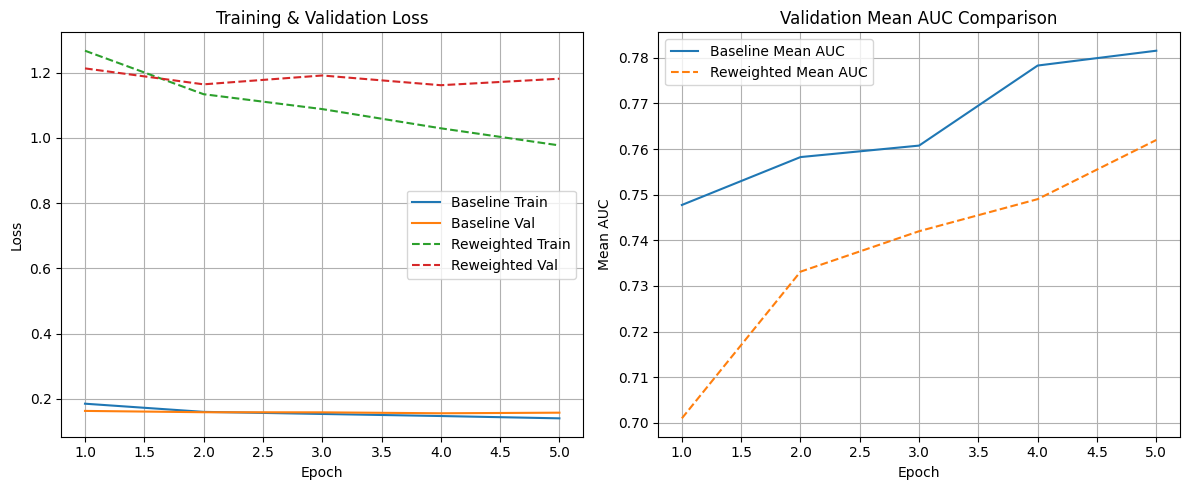

In [44]:
# Simple comparison of metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Loss curves
plt.subplot(1,2,1)
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Baseline Train')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Baseline Val')
plt.plot(range(1, NUM_EPOCHS_RW+1), train_losses_rw, '--', label='Reweighted Train')
plt.plot(range(1, NUM_EPOCHS_RW+1), val_losses_rw, '--', label='Reweighted Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)

# AUC curves
plt.subplot(1,2,2)
plt.plot(range(1, NUM_EPOCHS+1), val_aucs, label='Baseline Mean AUC')
plt.plot(range(1, NUM_EPOCHS_RW+1), val_aucs_rw, '--', label='Reweighted Mean AUC')
plt.xlabel('Epoch')
plt.ylabel('Mean AUC')
plt.title('Validation Mean AUC Comparison')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
